# Fianl Stage: Hybrid Link Prediction

## Construct the graph

### import & input

In [1]:
import nltk
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import networkx as nx
import csv
import operator

In [2]:
from sklearn import cross_validation
from random import choice

/home/luy0a/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
import random

In [4]:
import tensorflow as tf
hello = tf.constant('Hello, TensorFlow!')
sess = tf.Session()
print(sess.run(hello))

Hello, TensorFlow!


## Preprocessing

In [5]:
f_index = 'full_paper_index.txt'
f_links = 'full_paper_reference_links.txt'
d_index = pd.read_csv(f_index, sep='\t')
d_links = pd.read_csv(f_links, sep='\t')

In [6]:
d_index['title'][0]

'Complete Mining of Frequent Patterns from Graphs: Mining Graph Data'

Seems that some source papers appeared in reference_links are not in the index file. So use papers in index file to construct the mapper and consider them as nodes during computation. 

In [7]:
def construct_mapper(d, string):
    mapper={}
    for v in range(d.shape[0]):
        mapper.setdefault(v, d[string][v])
    print(v)
    return mapper

In [8]:
p_mapper = construct_mapper(d_index, 'paper_id')
a_mapper = construct_mapper(d_index, 'authors')
t_mapper = construct_mapper(d_index, 'title')

125916
125916
125916


In [9]:
def construct_mapper_r(d, string):
    mapper={}
    for v in range(d.shape[0]):
        mapper.setdefault(d[string][v], v)
    print(v)
    return mapper

In [10]:
p_mapper_r = construct_mapper_r(d_index, 'paper_id')
a_mapper_r = construct_mapper_r(d_index, 'authors')
t_mapper_r = construct_mapper_r(d_index, 'title')

125916
125916
125916


### Create reference graph using integers rather than indices in d_links

In [11]:
f = open('ref_graph.txt', 'w')
wr = csv.writer(f, delimiter='\t', quoting=csv.QUOTE_NONE)
for i in range(d_links.shape[0]):
    source = p_mapper_r.get(d_links['source'][i], -1)
    target = p_mapper_r.get(d_links['target'][i], -1)
    if (source != -1) and (target != -1):
        wr.writerow( (source, target) )
f.close()
ref_graph = np.loadtxt('ref_graph.txt', dtype='int', delimiter='\t')

## Construct the graphs
- Now we only need to use author_mapper2.txt, paper_mapper2.txt as mappers. 
- f_coauthor_links.txt and f_paper_reference_links.txt as edges. 

In [12]:
G_paper = nx.Graph()

In [13]:
G_paper.add_nodes_from(p_mapper.keys())

In [14]:
G_paper.add_edges_from(ref_graph)

## Link Predictions

In [ ]:
component_list = sorted(nx.connected_component_subgraphs(G_paper), key=len, reverse = True)
Gmax = component_list[0]

In [200]:
Gmax = nx.DiGraph()
N = np.loadtxt('p_nodes')
Gmax.add_nodes_from(N)
E = np.loadtxt('p_edges')
Gmax.add_edges_from(E)

In [223]:
# Randomly sample 1% of the nodes to form a subgraph
num_of_nodes = len(Gmax.nodes())
nodeIndices = np.array(random.sample(range(num_of_nodes), int(0.1*num_of_edges)))
N = N[nodeIndices]
Gmax_sub = Gmax.subgraph(N)
# 6422 edges, 14040 nodes

In [224]:
# mask 10% of the edges
num_of_edges = len(Gmax_sub.edges())
testEdgeIndices = np.array(random.sample(range(len(Gmax_sub.edges())), int(0.1*len(Gmax_sub.edges()))))
trainEdgeIndices = np.setdiff1d(range(len(Gmax_sub.edges())), testEdgeIndices)

In [361]:
G_paper_train = nx.DiGraph()
G_paper_train.add_nodes_from(Gmax_sub.nodes())
G_paper_train.add_edges_from(np.array(Gmax_sub.edges())[trainEdgeIndices])

In [362]:
print num_of_edges
n = len(Gmax_sub.edges())-len(G_paper_train.edges())
print len(G_paper_train.edges())
print n

6422
5174
1248


### Unsupervised: Jaccard, adamic/Adar

In [229]:
import heapq
def jaccard_sim(G, N):
    score = list(nx.jaccard_coefficient(G))
    ranked_score = heapq.nlargest(N, score, key = operator.itemgetter(2))
    return ranked_score

In [230]:
def adamic_adar_sim(G, N):
    score = list(nx.adamic_adar_index(G))
    ranked_score = heapq.nlargest(N, score, key = operator.itemgetter(2))
    return ranked_score

In [231]:
jac_result = jaccard_sim(G_paper_train, n)
ada_result = adamic_adar_sim(G_paper_train, n)

In [237]:
def result_writer(l, filename):
    f = open(filename, 'w')
    wr = csv.writer(f, delimiter=':', quoting=csv.QUOTE_NONE)
    for e in l:
        wr.writerow(e)
    f.close

In [239]:
result_writer(jac_result, 'jac')
result_writer(ada_result, 'ada')

## Link Prediction:: Supervised: Use title to judge similarity
    

In [166]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import sparse_random_matrix
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import KernelPCA
from sklearn import manifold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn.ensemble import RandomForestClassifier

In [17]:
stops = set(stopwords.words("english"))
lmtzr = WordNetLemmatizer()

def pre_processing_a_sentence(sentence, method):
    if method == 'BoW':
        # remove punctuations
        sentence_without_puncs = re.sub("[^a-zA-Z0-9]", " ", sentence)
        # Tokenization
        words_in_sentence = sentence_without_puncs.lower().split()
        # Remove stop words
        words_in_sentence = [w for w in words_in_sentence if not w in stops]
        ## Wordlists
        # words_in_sentence = [w for w in words_in_sentence if not w in BASIC]
        # Lemmatize
        words_lemmatized_in_sentence = []
        for w in words_in_sentence:
            w = lmtzr.lemmatize(w, pos = 'v')
            words_lemmatized_in_sentence.append(w)
    else:
        # remove punctuations
        sentence_without_puncs = re.sub("[^a-zA-Z0-9]", " ", sentence)
        # Tokenization
        words_in_sentence = sentence_without_puncs.lower()
        
        n2 = ngrams(words_in_sentence, n=2, punctuation=".,;:!?()[]{}`''\"@#$^&*+-|=~_", continuous=False)
        joined_n2=[]
        for phrase_words in n2:
            joined_n2.append('-'.join(phrase_words))
            
        n3 = ngrams(words_in_sentence, n=3, punctuation=".,;:!?()[]{}`''\"@#$^&*+-|=~_", continuous=False)
        joined_n3=[]
        for phrase_words in n3:
            joined_n3.append('-'.join(phrase_words))
            
        words_lemmatized_in_sentence = []
        words_lemmatized_in_sentence.extend(joined_n2)
        words_lemmatized_in_sentence.extend(joined_n3)
        
    return words_lemmatized_in_sentence

def pre_processing(sentence_array, method):
    num = sentence_array.size
    words_array_clean = []
    
    # delete "NaN" (if there's any)
    sentence_array_nan_indices = pd.isnull(sentence_array)
    for i in xrange( 0, num ):
        if(sentence_array_nan_indices[i] == False):
            words_array_clean.append( str(pre_processing_a_sentence( sentence_array[i], method ) ) )
        else:
            words_array_clean.append( ' ' )
            
    return words_array_clean

vectorizer_title = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 10000) # 600*10 = 6000

def feature_generation(word_array, vectorizer):
    feature_array = vectorizer.fit_transform(word_array).toarray()
    feature_list = vectorizer.get_feature_names()
    return feature_array, feature_list

In [18]:
titles = np.array(d_index['title'])
w_title = pre_processing(titles, 'BoW')
feature_array_title, feature_list_title = feature_generation(w_title, vectorizer_title)

In [19]:
def PCA_analysis(feature_array, n):# find first n highest variances
    pca = PCA(n_components = n) 
    pca.fit(feature_array)
    feature_array_pca = pca.transform(feature_array)
    
    plt.figure(1)
    
    plt.subplot(211)
    plt.plot(pca.explained_variance_ratio_, 'ro')
    plt.ylabel('Percentage of variances')
    leg = plt.legend(loc='best', ncol=2, mode="expand", shadow=True, fancybox=True)
    #leg.get_frame().set_alpha(0.5)
    
    plt.subplot(212)
    plt.plot(pca.singular_values_, 'bo')
    plt.ylabel('Singular values')
    leg = plt.legend(loc='best', ncol=2, mode="expand", shadow=True, fancybox=True)
    #leg.get_frame().set_alpha(0.5)
    plt.show()
    
    return feature_array_pca

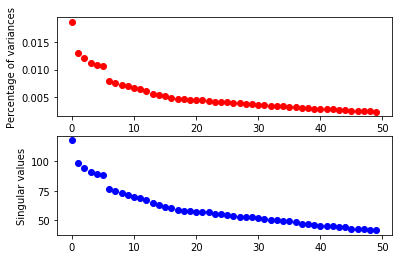

In [20]:
feature_array_title_pca = PCA_analysis(feature_array_title, 50)

In [76]:
len(G_paper.edges())

140250

In [22]:
np.shape(feature_array_title_pca)

(125917, 50)

In [23]:
def scatter_visualization_3D(data_array):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(data_array[:,0], data_array[:,1], data_array[:,2], c='red', s=10, label='Papers',
               alpha=0.3, edgecolors='none')
    ax.legend()
    ax.grid(True)
    plt.show()

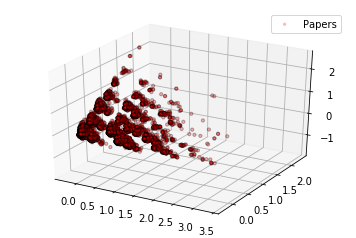

In [24]:
scatter_visualization_3D(feature_array_title_pca)

In [142]:
trainEdgeIndices = random.sample(range(len(ref_graph)), int(0.005*len(ref_graph))) # 878 edges sampled

trainNodes = []
trainEdges = ref_graph[trainEdgeIndices]
for edge in trainEdges:
    for node in edge:
        if not node in trainNodes:
            trainNodes.append(node) # 1629 nodes sampled

trainFeatures = []
trainLabels = []
for i in trainNodes:
    for j in trainNodes:
        if i != j:
            trainFeatures.append(np.absolute(feature_array_title_pca[i]-feature_array_title_pca[j]))
            if [i, j] in trainEdges:
                trainLabels.append(1)
            else:
                trainLabels.append(0)

In [91]:
def similarity(a, b):
    s = np.dot(feature_array_title_pca[a], feature_array_title_pca[b].T)
    if s == 0:
        return s
    else:
        s = s / (np.linalg.norm(feature_array_title_pca[a])*np.linalg.norm(feature_array_title_pca[b]))
        return s

False

In [164]:
xTrain1, xPlot, yTrain1, yPlot = cross_validation.train_test_split(trainFeatures, trainLabels, 
                                                                 test_size=0.3, random_state = 0)

In [167]:
clf = RandomForestClassifier(
        criterion = 'entropy', #gini
        n_estimators=100, 
        max_features=2,
        max_depth = 25,   
        min_samples_split = 20,
        min_samples_leaf = 1,
        n_jobs = 4,
        random_state = 0
       )

In [168]:
clf.fit(xTrain1, yTrain1)
print clf.score(xTrain1, yTrain1)
print clf.score(xPlot, yPlot)

0.756435007822
0.7558886079


In [189]:
def official_plot(xPlot, yPlot):
    X0, X1 = [item[0] for item in xPlot], [item[1] for item in xPlot]
    xx, yy = make_meshgrid(X0, X1)
    
    fig = plt.figure
    
    plot_contours(plt, clf, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
    plt.scatter(X0, X1, c=yPlot, cmap=plt.cm.coolwarm, s=20, edgecolors='k')  
    plt.show()
    

def make_meshgrid(x, y, h=.5):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    xa = np.array(x)
    ya = np.array(y)
    x_min, x_max = xa.min() - 1, xa.max() + 1
    y_min, y_max = ya.min() - 1, ya.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
#   Z = clf.predict(xPlot[1:-1,:])
    Z = clf.predict(np.transpose([xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

In [195]:
# Try only use 2 features
trainFeatures2 = []
for i in trainNodes:
    for j in trainNodes:
        if i != j:
            trainFeatures2.append(np.absolute(feature_array_title_pca[i][0:2]-feature_array_title_pca[j][0:2]))

In [198]:
xTrain2, xPlot2, yTrain2, yPlot2 = cross_validation.train_test_split(trainFeatures2, trainLabels, 
                                                                 test_size=0.3, random_state = 0)
clf.fit(xTrain2, yTrain2)
print clf.score(xTrain2, yTrain2)

0.756611154444


### Try different similarity metrics

In [396]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import cross_validation
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

In [404]:
clf1 = AdaBoostClassifier(n_estimators=350, learning_rate=0.05)

In [405]:
clf1.fit(xTrain1, yTrain1)
print clf1.score(xTrain1, yTrain1)
print clf1.score(xPlot, yPlot)

0.756272328066
0.756295845672


In [403]:
# NN
from sklearn.neural_network import MLPClassifier
clf2 = MLPClassifier(alpha=1) 
clf2.fit(xTrain1, yTrain1) 
print clf2.score(xTrain1, yTrain1) 
print clf.score(xPlot, yPlot)

0.756272328066
0.7558886079


## Matrix factorization

In [273]:
np.array(list(G_paper_train.edges())).astype(int)

array([[ 32769, 108546],
       [     2, 116919],
       [     4,  10177],
       ..., 
       [ 32332,  32518],
       [ 32379,  32402],
       [107802,  65424]])

In [363]:
testEdgeIndices = np.array(random.sample(range(len(G_paper_train.edges())), int(0.1*len(G_paper_train.edges()))))
trainEdgeIndices = np.setdiff1d(range(len(G_paper_train.edges())), testEdgeIndices)
G_t = nx.DiGraph()
G_t.add_nodes_from(G_paper_train.nodes())
G_t.add_edges_from(np.array(list(G_paper_train.edges())).astype(int)[trainEdgeIndices])

In [364]:
P = nx.adjacency_matrix(G_t)

In [342]:
np.linalg.matrix_rank(Ptrain)

2272

In [384]:
Ptrain = P.todense()
n = P.shape[0]
print(Ptrain.shape)
k = 100
tf.reset_default_graph()
Pt = tf.get_variable("Ptrain", initializer = tf.constant(Ptrain.astype(np.float32)))
# Weights = tf.maximum(0.0001, Ptrain)
Weights = tf.maximum(0., Ptrain)
W = tf.get_variable("W", shape = [n,k])
H = tf.get_variable("H", shape = [n,k])
Prediction = tf.matmul(W, H, transpose_b = True)
Loss = tf.reduce_sum(tf.square(Prediction - Pt) * Weights)

reg_coeff = 0.00001
regularizer = reg_coeff * (tf.square(tf.norm(H)))

Loss = Loss + regularizer

learning_rate = 0.003
train_step = tf.train.AdamOptimizer(learning_rate).minimize(Loss)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(100):
        print(epoch)
        sess.run(train_step)
        current_loss = sess.run(Loss)
        print("loss = " + str(current_loss))
    PredictionMatrix = sess.run(Prediction)


(14010, 14010)
0
loss = 4593.17
1
loss = 4527.58
2
loss = 4456.81
3
loss = 4378.59
4
loss = 4291.46
5
loss = 4194.56
6
loss = 4087.38
7
loss = 3969.65
8
loss = 3841.29
9
loss = 3702.38
10
loss = 3553.13
11
loss = 3393.92
12
loss = 3225.26
13
loss = 3047.83
14
loss = 2862.48
15
loss = 2670.28
16
loss = 2472.47
17
loss = 2270.51
18
loss = 2066.09
19
loss = 1861.09
20
loss = 1657.63
21
loss = 1458.0
22
loss = 1264.67
23
loss = 1080.2
24
loss = 907.235
25
loss = 748.351
26
loss = 605.959
27
loss = 482.138
28
loss = 378.443
29
loss = 295.694
30
loss = 233.775
31
loss = 191.486
32
loss = 166.513
33
loss = 155.552
34
loss = 154.621
35
loss = 159.516
36
loss = 166.305
37
loss = 171.76
38
loss = 173.618
39
loss = 170.66
40
loss = 162.628
41
loss = 150.036
42
loss = 133.927
43
loss = 115.632
44
loss = 96.5553
45
loss = 77.9982
46
loss = 61.0397
47
loss = 46.4644
48
loss = 34.7355
49
loss = 26.0072
50
loss = 20.1634
51
loss = 16.8761
52
loss = 15.6717
53
loss = 15.9987
54
loss = 17.2902
55
loss =

In [314]:
node_mapper = {}
iter = 0 
for node in G_t.nodes():
    node_mapper[node] = iter
    iter+=1

In [315]:
remapped_edges = [(node_mapper[node1], node_mapper[node2]) for node1, node2 in list(G_t.edges())]

In [316]:
remapped_edges = set(remapped_edges)

In [ ]:
edge_list = list(G_paper_train.edges())
test_edges = [edge_list[i] for i in testEdgeIndices]
test_edges = set([(node_mapper[node1], node_mapper[node2]) for node1, node2 in test_edges])

In [366]:
edges_to_sort = [[ j for j in range(n) if (i,j) not in remapped_edges ] for i in range(n)]

In [367]:
K = 100
predicted = set()
for i in range(n):
    nodes_to_sort = edges_to_sort[i]
    p = heapq.nlargest(K, nodes_to_sort, key = lambda j : PredictionMatrix[i][j])
    for j in p:
        predicted.add( (i,j))

In [385]:
HRS = []
hits = np.zeros(100)
K = 100
predicted = set()
for i in range(n):
    nodes_to_sort = edges_to_sort[i]
    p = heapq.nlargest(K, nodes_to_sort, key = lambda j : PredictionMatrix[i][j])
    for k in range(K):
        j = p[k]
        if (i,j) in test_edges: 
            for kk in range(k, K):
                hits[kk] = hits[kk] + 1

In [386]:
for i in range(K):
    HRS.append(hits[i]/len(test_edges))

In [388]:
HRS

[0.3902439024390244,
 0.47212543554006969,
 0.50348432055749126,
 0.51567944250871078,
 0.52090592334494779,
 0.52264808362369342,
 0.52439024390243905,
 0.52439024390243905,
 0.52613240418118468,
 0.52787456445993031,
 0.53135888501742157,
 0.53135888501742157,
 0.5331010452961672,
 0.53484320557491294,
 0.53484320557491294,
 0.53484320557491294,
 0.53484320557491294,
 0.53484320557491294,
 0.53484320557491294,
 0.53658536585365857,
 0.5383275261324042,
 0.5383275261324042,
 0.5383275261324042,
 0.5383275261324042,
 0.5383275261324042,
 0.5383275261324042,
 0.5383275261324042,
 0.5383275261324042,
 0.5383275261324042,
 0.5383275261324042,
 0.5383275261324042,
 0.54006968641114983,
 0.54006968641114983,
 0.54181184668989546,
 0.54181184668989546,
 0.54181184668989546,
 0.54181184668989546,
 0.54181184668989546,
 0.54181184668989546,
 0.54181184668989546,
 0.54181184668989546,
 0.54181184668989546,
 0.54181184668989546,
 0.54181184668989546,
 0.54181184668989546,
 0.54181184668989546,
 

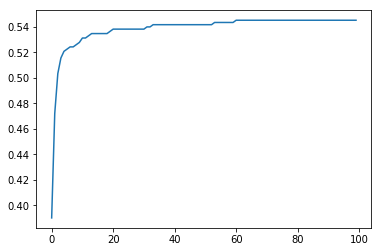

In [387]:
plt.plot(HRS)
plt.show()